# 3) Homography estimation

In [1]:
# libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

### a) estimate homography

In [2]:
from random import randint


def get_matrix_condition_for_single_point(p_r, p_t):
    x_r, y_r = p_r
    x_t, y_t = p_t
    M = np.array([
        [x_r, y_r, 1, 0, 0, 0, -x_t * x_r, -x_t * y_r, -x_t],
        [0, 0, 0, x_r, y_r, 1, -y_t * x_r, -y_t * y_r, -y_t]
    ])
    return M


def construct_A(pts1, pts2):
    matrices_for_single_points = [get_matrix_condition_for_single_point(p_r, p_t) for p_r, p_t in zip(pts1, pts2)]
    return np.concatenate(matrices_for_single_points, axis=0)


def compute_h(V):
    return V[8, :] / V[8, 8]


def estimate_homography(pts1, pts2):
    A = construct_A(pts1, pts2)
    [_, _, V] = np.linalg.svd(A)
    h = compute_h(V)
    return h.reshape((3, 3))


# function for check the correctness of homography
def get_coresponding_point(p, H):
    p2 = H.dot(np.array([p[0], p[1], 1]))
    return [round(p2[0] / p2[2]), round(p2[1] / p2[2])]


# function for check the correctness of homography
def check_homography(pt1, pt2, H):
    estimated_p2s = [get_coresponding_point(p, H) for p in pt1]
    for p2, estim_p2 in zip(pt2, estimated_p2s):
        print(f'{p2} - {estim_p2}')


# check the fuction estimate_homography
pt1 = [[i, randint(0, 100)] for i in range(6)]
pt2 = [[j, i] for i, j in pt1]
H = estimate_homography(pt1, pt2)
check_homography(pt1, pt2, H)

[63, 0] - [63, 0]
[78, 1] - [78, 1]
[21, 2] - [21, 2]
[51, 3] - [51, 3]
[50, 4] - [50, 4]
[90, 5] - [90, 5]


b) Homography on images

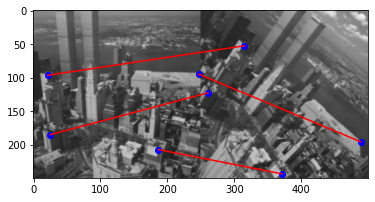

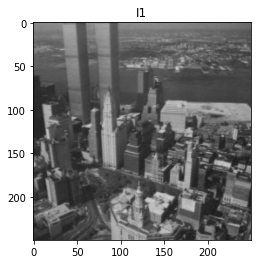

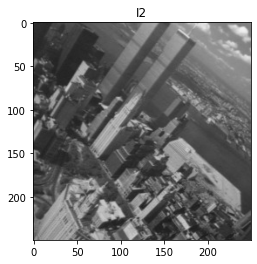

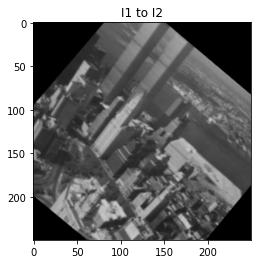

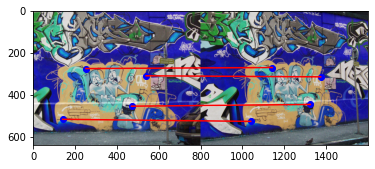

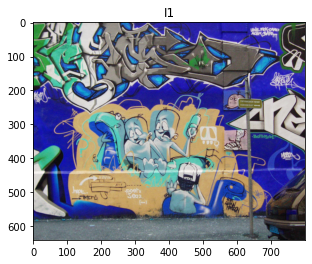

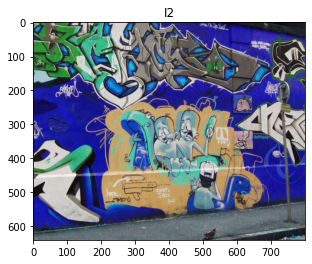

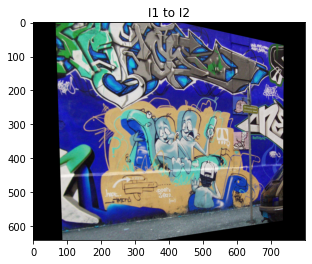

In [3]:
from my_utils import read_data, show_images
from a4_utils import display_matches

#New york
newyork1 = cv2.imread("data/newyork/newyork1.jpg")
newyork2 = cv2.imread("data/newyork/newyork2.jpg")

points = read_data('data/newyork/newyork.txt').reshape((4, 4))
pt1 = [[x, y] for x, y in zip(points[:, 0], points[:, 1])]
pt2 = [[x, y] for x, y in zip(points[:, 2], points[:, 3])]

display_matches(newyork1, newyork2, pt1, pt2, [(i, i) for i in range(len(pt1))])
H = estimate_homography(pt1, pt2)
warp_im = cv2.warpPerspective(newyork1, H, (newyork2.shape[1], newyork2.shape[0]))
show_images([newyork1, newyork2, warp_im], ['I1', 'I2', 'I1 to I2'])

#Graf
graf1 = cv2.imread("data/graf/graf1.jpg")
graf2 = cv2.imread("data/graf/graf2.jpg")

points = read_data('data/graf/graf.txt').reshape((4, 4))
pt1 = [[x, y] for x, y in zip(points[:, 0], points[:, 1])]
pt2 = [[x, y] for x, y in zip(points[:, 2], points[:, 3])]

display_matches(graf1, graf2, pt1, pt2, [(i, i) for i in range(len(pt1))])
H = estimate_homography(pt1, pt2)
warp_im = cv2.warpPerspective(graf1, H, (graf2.shape[1], graf2.shape[0]))
show_images([graf1, graf2, warp_im], ['I1', 'I2', 'I1 to I2'])

c) warp images


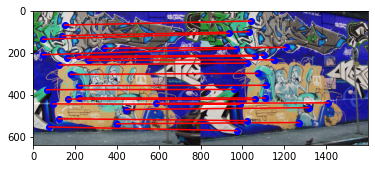

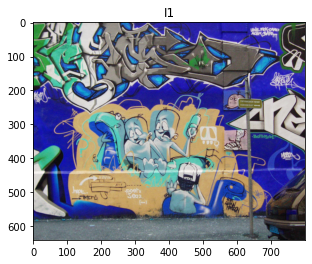

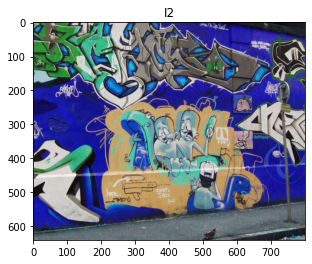

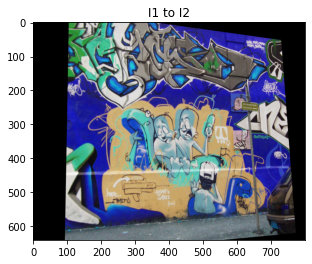

In [10]:
from my_utils import helinger, harris_points


def find_correspodences_symetric(I1, descriptors1, I2, descriptors2):
    correspondences_1to2 = dict()
    correspondences_2to1 = dict()
    for indx, desc1 in enumerate(descriptors1):
        dist = [(i, helinger(desc1, desc2)) for i, desc2 in enumerate(descriptors2)]
        nearest_point = min(dist, key=lambda x: x[1])
        correspondences_1to2[indx] = nearest_point
    for indx, desc2 in enumerate(descriptors2):
        dist = [(i, helinger(desc1, desc2)) for i, desc1 in enumerate(descriptors1)]
        nearest_point = min(dist, key=lambda x: x[1])
        correspondences_2to1[indx] = nearest_point
    correspondences = [(i1, i2[0], i2[1]) for i1, i2 in correspondences_1to2.items() if
                       correspondences_2to1[i2[0]][0] == i1]  # [(idx of p1, idx of p2, dist), ...]

    sorted_correspondences = [(idx1, idx2) for idx1, idx2, dist in
                              sorted(correspondences,
                                     key=lambda x: x[2])]  #[(idx of p1, idx of p2), ...] sorted by distance

    return sorted_correspondences[:20]


from a4_utils import simple_descriptors


def find_matches(I1, I2):
    sigma = 12
    threshold = 10000
    ps1 = harris_points(I1, sigma, threshold)
    ps2 = harris_points(I2, sigma, threshold)
    desc1 = simple_descriptors(I1, ps1)
    desc2 = simple_descriptors(I2, ps2)
    corr = find_correspodences_symetric(I1, desc1, I2, desc2)
    return ps1, ps2, corr


def warp_images(im1, im2):
    ps1, ps2, corr = find_matches(im1, im2)
    display_matches(im1, im2, ps1, ps2, corr)
    ps1_good = [ps1[indx] for indx, _ in corr]
    ps2_good = [ps2[indx] for _, indx in corr]
    H = estimate_homography(ps1_good, ps2_good)
    warp_im = cv2.warpPerspective(im1, H, (im2.shape[1], im2.shape[0]))
    show_images([im1, im2, warp_im], ['I1', 'I2', 'I1 to I2'])


graf1 = cv2.imread("data/graf/graf1.jpg")
graf2 = cv2.imread("data/graf/graf2.jpg")

warp_images(graf1, graf2)
